In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff

In [2]:
def constantlayers_to_log(vp,interfacedepths,z):
    ''' 
    vp[0] corresponds to velocity of first layer 
    '''
    dz = z[1]
    
    z_old = np.hstack([z[0],interfacedepths,z[-1]])
    f_vp = sc.interpolate.interp1d(z_old, np.hstack([vp,vp[-1]]), kind='previous')
    return f_vp(z)

In [3]:
nx, nz = 201, 201
dx, dz = 10, 10
x, z = np.arange(nx)*dx, np.arange(nz)*dz

# VELOCITY MODELS

(0.0, 2000.0)

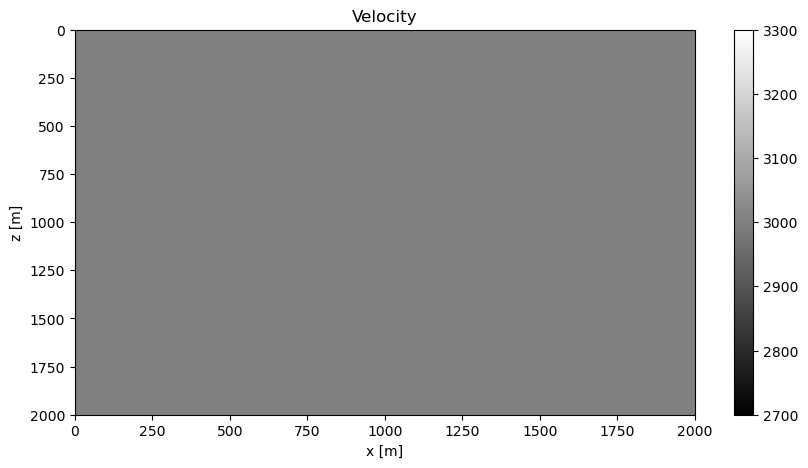

In [4]:
# Velocity Model
v0 = 3000 # initial velocity
vp_homo = np.outer(np.ones(nx), v0) 

plt.figure(figsize=(10,5))
im = plt.imshow(vp_homo.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

(0.0, 2000.0)

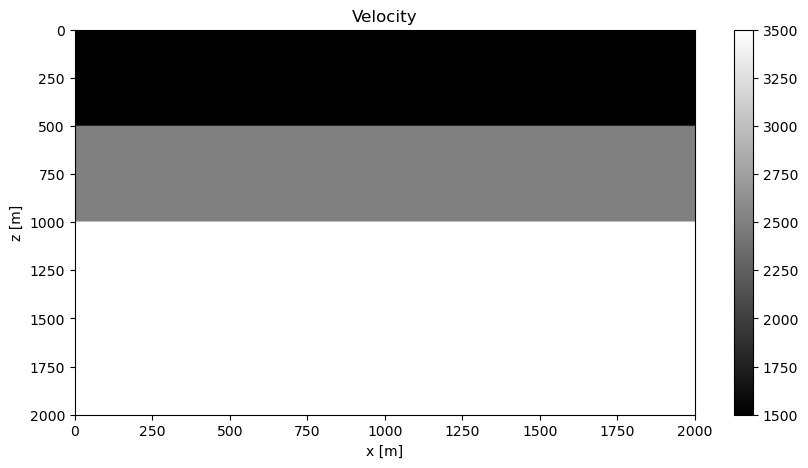

In [5]:
vp_layers = [1500, 2500, 3500]
interfacedepths = [500, 1000]

vp_1D  = constantlayers_to_log(vp_layers,interfacedepths,z)
vp_3L = np.expand_dims(vp_1D, axis=[0])
vp_3L = vp_3L.repeat(nx,axis=0)


plt.figure(figsize=(10,5))
im = plt.imshow(vp_3L.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Velocity')
plt.xlim(x[0], x[-1])

# RECEIVERS & SOURCES

In [6]:
# SOURCE
# change
sx = nx//2  # Source x location
sz = 3*nz//4  # Source y location
s_amp = 1  # Source amplitude

# -------------------------------
# Don't change
source = np.zeros((nx, nz))
source[sx,sz]=s_amp

In [7]:
# RECEIVERS
# change
nr_x = 30  # number of receivers regularly placed along the surface


rec_buffer = 10 # steps in from the edge as function of gridpoints
r_z_loc = 0 # Surface receivers


# -------------------------------
# Don't change
r_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)
rx, rz = np.meshgrid(r_x_locs,r_z_loc)
recs = np.vstack((rx.flatten(), rz.flatten()))
nr = recs.shape[1]

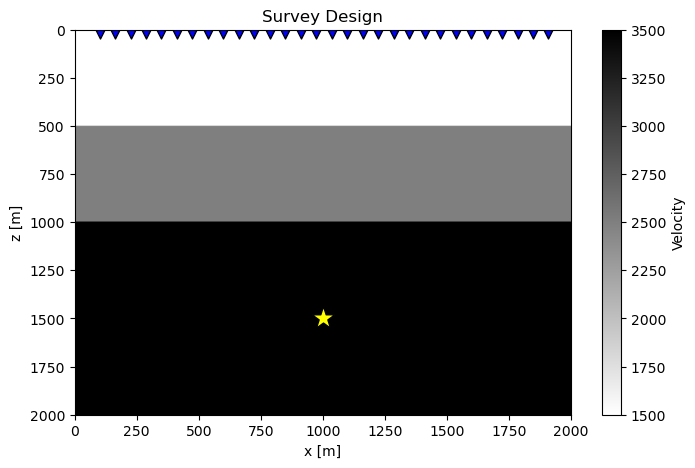

In [8]:
plt.figure(figsize=(8,5))
im = plt.imshow(vp_3L.T, cmap='binary', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(x[sx], z[sz], marker='*', s=300, c='yellow', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('z [m]')
plt.title('Survey Design')
plt.colorbar(im, label='Velocity')
plt.xlim(x[0], x[-1]);

# FOR INTEREST ONLY < TRAVELTIMES

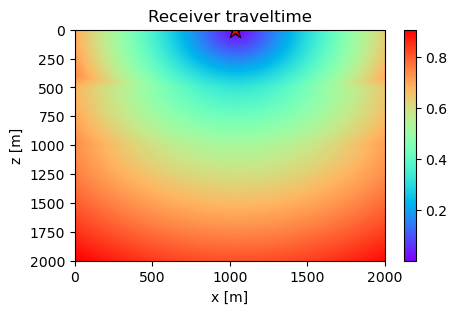

In [9]:
trav = Kirchhoff._traveltime_table(z, x, recs, recs, 
                                   vp_3L, # <- change between vp_homo and vp_3L, or new vel model you make :)
                                   mode='eikonal')[1]


# JUST PLOTTING
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
im = ax.imshow(trav[:, nr//2].reshape((nx, nz)).T, cmap='rainbow', 
               extent = (x[0], x[-1], z[-1], z[0]))
ax.scatter(recs[0, nr//2], recs[1, nr//2], marker='*', s=150, c='r', edgecolors='k')
ax.axis('tight')
ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax.set_title('Receiver traveltime')
ax.set_ylim(z[-1], z[0])
plt.colorbar(im, ax=ax);

# FORWARD MODELLING

In [10]:
# Set wavelet and time sampling
nt = 501  # two seconds at 4ms sampling
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=40) # Central frequency 20Hz


In [11]:
# INITIALISE OPERATOR
Op = Kirchhoff(z, x, t, np.expand_dims(recs[:,0],1), recs, 
               vp_3L,  # <- change between vp_homo and vp_3L, or new vel model you make :)
               wav, wavc, mode='eikonal', engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-3040.0916238596983 - u^H(Op^Hv)=-3040.0916238596965


In [12]:
# PERFORM FORWARD (MODEL)
eventdata = Op @ source.squeeze()

Text(0.5, 25.722222222222214, 'Amplitude')

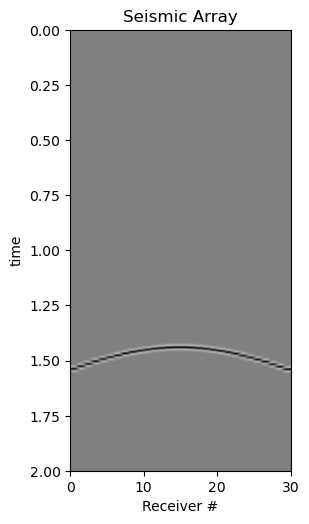

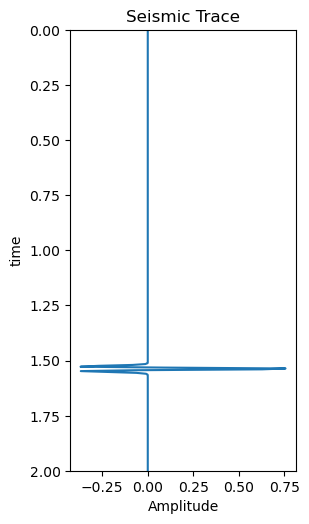

In [13]:
fig,ax=plt.subplots(1,1,figsize=(3,5))
ax.imshow(eventdata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1, extent=[0, nr, t[-1], t[0]])
plt.tight_layout()
plt.title('Seismic Array')
plt.ylabel('time')
plt.xlabel('Receiver #')

fig,ax=plt.subplots(1,1,figsize=(3,5))
ax.plot(eventdata[:,0].squeeze(),t)
ax.set_ylim([t[-1],t[0]])
plt.tight_layout()
plt.title('Seismic Trace')
plt.ylabel('time')
plt.xlabel('Amplitude')

# TMP - MASK DESIGN FOR SEG PRES

In [33]:

def jacobian_corruption(patch, local_mask, num_activepixels, mask_window=31, crpt_amp=1e-4):
    '''mask_window accounts for pixels choosen near edge of patch
    '''
    # To enforce active pixel to be masked
    half_win = int(0.5*(mask_window-1))
    local_mask[half_win,half_win] = 1
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP ONE: SELECT ACTIVE PIXEL LOCATIONS
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)
    id_aps = (idx_aps, idy_aps)

    ap_mask = np.ones_like(patch)
    ap_mask[id_aps] = 0.

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP TWO: MAKE MASK PATCH
    mask_patch_lrg = np.zeros([patch.shape[0]+mask_window, patch.shape[1]+mask_window])
    for i in range(len(idx_aps)):
        apx = idx_aps[i]
        apy = idy_aps[i]
        mask_patch_lrg[apx:apx+mask_window,apy:apy+mask_window] += local_mask

    mask_patch = mask_patch_lrg[half_win:-half_win-1, half_win:-half_win-1]
    mask_patch[np.where(mask_patch > 1)] = 1
    crpt_mask = abs(np.ones_like(mask_patch)-mask_patch)

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
    # STEP THREE: PERFORM CORRUPTION
    corrupt_patch_noise = (crpt_amp * np.random.randn(crpt_mask.shape[0],crpt_mask.shape[1])) * mask_patch
    corrupt_patch_data = patch * crpt_mask

    return corrupt_patch_noise + corrupt_patch_data, crpt_mask, ap_mask




In [34]:
def create_signal_mask(mask_width=3, size=64):
    
    giant_mask_w_line = np.zeros([int(size*4)+1,int(size*4)+1])
    hlfsize = int((giant_mask_w_line.shape[0]-1)/2)
    giant_mask_w_line[:,hlfsize-1:hlfsize] = 1
    giant_mask_w_line[hlfsize-1-mask_width:hlfsize+mask_width,
                      hlfsize-1-mask_width:hlfsize+mask_width] = 1
    
    midpoint = int((giant_mask_w_line.shape[0]-1)/2)
    mask = giant_mask_w_line[int(midpoint-size/2)-1:int(midpoint+size/2),
                       int(midpoint-size/2)-1:int(midpoint+size/2)]
    return mask

In [70]:
dc_mask = create_signal_mask(mask_width=1, size=30,)
ap = np.zeros_like(dc_mask)
ap[15,15]=1

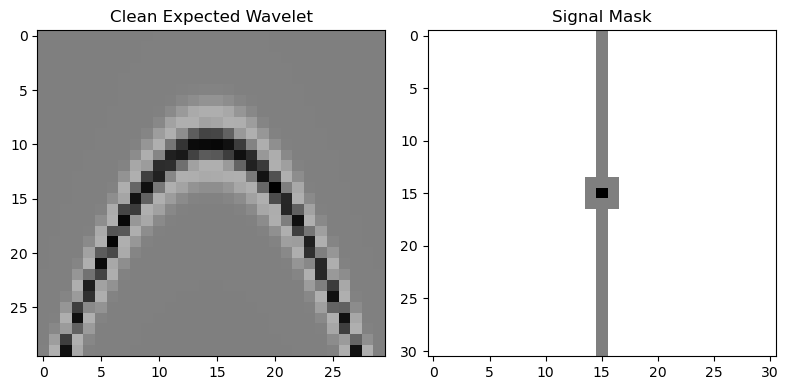

In [71]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(eventdata[0,:,350:380].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Clean Expected Wavelet')
axs[1].imshow(dc_mask+ap, aspect='auto', cmap='binary', vmin=0, vmax=2)
axs[1].set_title('Signal Mask')
plt.tight_layout()

In [74]:
np.random.seed(512)
crpt_1, msk1, ap1 = jacobian_corruption(eventdata[0,:,350:380].T.squeeze(), 
                             dc_mask, 
                             num_activepixels=1, 
                             mask_window=31, 
                             crpt_amp=1e-4)

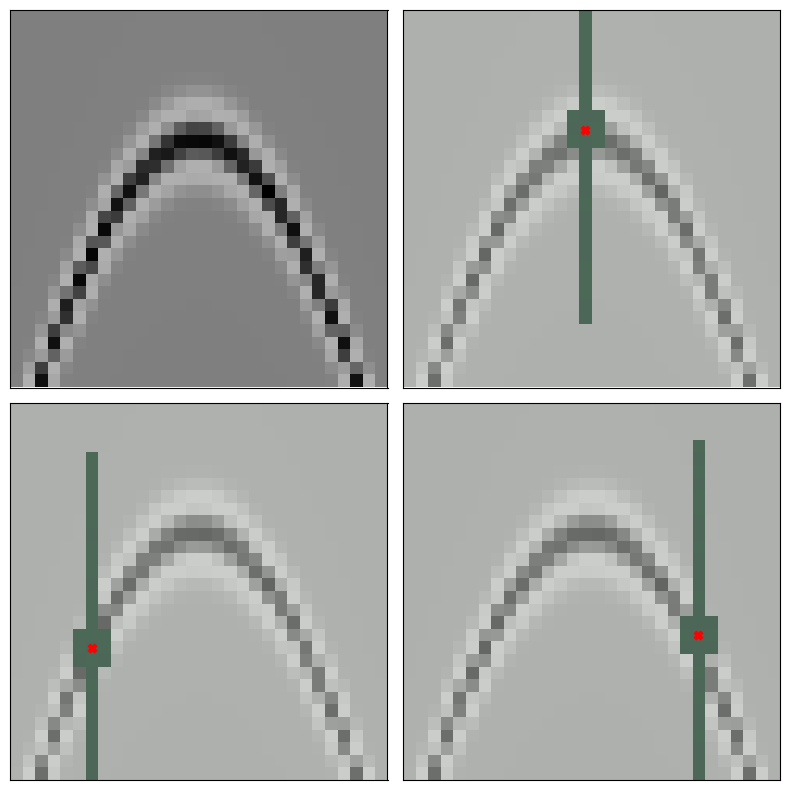

In [109]:
seed_list = [16,23,31]
fig,axs = plt.subplots(2,2,figsize=(8,8))
axs.ravel()[0].imshow(eventdata[0,:,350:380].T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
for i in range(1,4):
    np.random.seed(seed_list[i-1])
    crpt_1, msk1, ap1 = jacobian_corruption(eventdata[0,:,350:380].T.squeeze(), 
                                 dc_mask, 
                                 num_activepixels=1, 
                                 mask_window=31, 
                                 crpt_amp=1e-4)
    axs.ravel()[i].imshow(crpt_1, aspect='auto', cmap='binary', vmin=-1, vmax=1)
    axs.ravel()[i].imshow(msk1, aspect='auto', cmap='Greens_r', vmin=0, vmax=1, alpha=0.4)
    axs.ravel()[i].scatter(np.where(ap1==0.)[1],np.where(ap1==0.)[0],marker='X', facecolor='red')
for ax in axs.ravel():ax.set_yticks([]);ax.set_xticks([]);
plt.tight_layout()

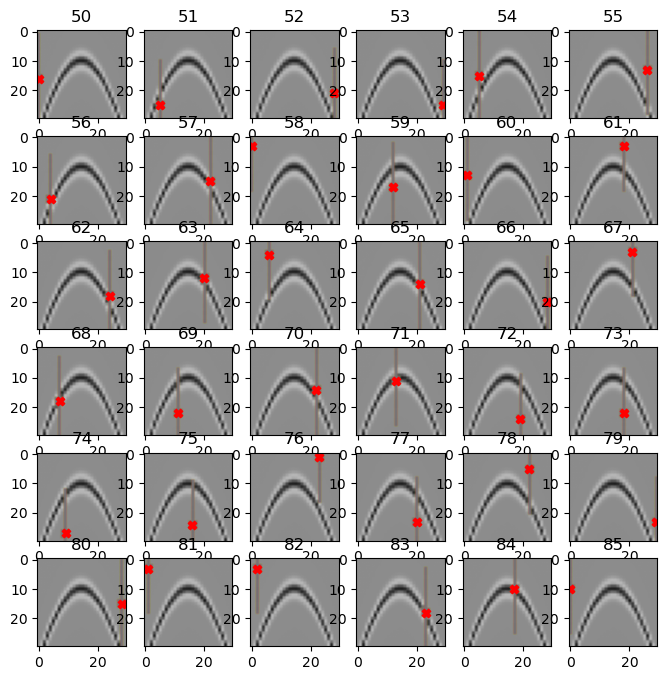

In [90]:
fig,axs = plt.subplots(6,6,figsize=(8,8))
for i in range(len(axs.ravel())):
    np.random.seed(50+i)
    crpt_1, msk1, ap1 = jacobian_corruption(eventdata[0,:,350:380].T.squeeze(), 
                                 dc_mask, 
                                 num_activepixels=1, 
                                 mask_window=31, 
                                 crpt_amp=1e-4)
    axs.ravel()[i].imshow(crpt_1, aspect='auto', cmap='binary', vmin=-1, vmax=1)
    axs.ravel()[i].imshow(msk1, aspect='auto', cmap='hot', vmin=0, vmax=1, alpha=0.1)
    axs.ravel()[i].scatter(np.where(ap1==0.)[1],np.where(ap1==0.)[0],marker='X', facecolor='red')
    axs.ravel()[i].set_title(50+i)